In [2]:
!pip install panel --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import numpy as np
import pandas as pd
import panel as pn
import datetime as dt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import folium
import branca.colormap as cm
from panel.interact import interact, interactive, fixed, interact_manual
pn.extension()

In [10]:
data = pd.read_csv('data_june.csv')
regnames = pd.read_csv('nonzero_regions.csv')
regnames = regnames['0']

regions = pd.read_csv('regions.csv', sep=';')
regions = regions.iloc[regnames.to_list()]

In [12]:
def data_plot(lag, reg, start, end):
    
    temp = dd[reg].loc[(dd[reg].index >= start) & (dd[reg].index <= end)]
    
    y_name = 'y'+str(lag)
    fig = Figure(figsize=(6,4))
    FigureCanvas(fig)
    ax=fig.add_subplot()

    ax.plot(temp[y_name], color='#4682B4')
    ax.plot(temp[y_name+'_t'], color='#B22222')

    ax.tick_params(which='major', labelsize=6)
    
    ax.set_ylabel('Количество поездок в такси в регионе '+str(reg))
    ax.set_xlabel('Период наблюдения')
    ax.legend( ['Фактические данные', 'lightgbm прогноз'], loc=1, ncol = 2, prop={'size':10})
    
    fig = pn.panel(fig)
    return fig

In [13]:
def prep_dataset(data):
    data_dict = {}
    for i in range(102):
        ind = 715 + i*715
        temp = data.iloc[ind-715:ind]
        temp = temp.set_index('time')
        temp.index = pd.to_datetime(temp.index)
        data_dict[data.iloc[ind-715:ind]['reg'].values[0]] = temp
    return data_dict

dd = prep_dataset(data)

In [14]:
def update_values_d(event):
    if event.new > date_widgets[1].value:
        date_widgets[1].value = event.new
        date_widgets[1].start = event.new
    else:
        date_widgets[1].start = event.new
    
    widg_col_ser[1] = data_plot(param_widgets[0].value, param_widgets[1].value, date_widgets[0].value,
                                         date_widgets[1].value)

def update_values(event):
    widg_col_ser[1] = data_plot(param_widgets[0].value, param_widgets[1].value, date_widgets[0].value,
                                         date_widgets[1].value)

In [15]:
# вкладка с графиком 
date_slider_start = pn.widgets.DateSlider(name='Введите дату начала прогноза', 
                                            start = dt.datetime(2016, 6, 1),# наименьшее возможное время  
                                            end = dt.datetime(2016, 6, 30),#наибольшее возможное время
                                            value=dt.datetime(2016, 6, 1), as_datetime=True)

date_slider_end = pn.widgets.DateSlider(name='Введите дату окончания прогноза', 
                                            start = dt.datetime(2016, 6, 1),# наименьшее возможное время  
                                            end = dt.datetime(2016, 6, 30),#наибольшее возможное время
                                            value=dt.datetime(2016, 6, 2), as_datetime=True)

date_widgets = pn.WidgetBox(date_slider_start, date_slider_end, height=120, width=400)

lag_slider=pn.widgets.IntSlider(name='Временной лаг в часах', value=1,  start=1, end=6, step=1)
select_reg = pn.widgets.Select(name='Выберите регион для прогноза:', #подпись виджета
                           options=regnames.to_list(),#Список или словарь опций для выбора
                           size=1)

param_widgets = pn.WidgetBox(lag_slider, select_reg, height=120, width=400)

widg_row=pn.Row(date_widgets,param_widgets)

widg_col_ser = pn.Column(widg_row, data_plot(param_widgets[0].value, param_widgets[1].value, date_widgets[0].value,
                                         date_widgets[1].value), name='График')

date_slider_start.param.watch(update_values_d, 'value')
date_slider_end.param.watch(update_values, 'value')
lag_slider.param.watch(update_values, 'value')
select_reg.param.watch(update_values, 'value')
print('__')

__


In [16]:
NY_border={'W': -74.25559, 'E': -73.70001, 'S': 40.49612, 'N': 40.91553}
cx, cy =  (NY_border['S'] + NY_border['N']) / 2, (NY_border['W'] + NY_border['E']) / 2
colormap_new = cm.LinearColormap(colors=['#FFD700', '#F08080', '#FF0000', '#B22222', '#800000'],
                                          index = np.round(np.linspace(0, 859, 5)),
                                          vmin = 0, vmax = 859)

def coloring(x):
    if x==0:
        return('#FFFFFF')
    else: return(colormap_new(int(x)))

def mapping(time, lag, name):
    m = folium.Map(location=[cx, cy], min_zoom=10 ,max_zoom=13)

    for (i,reg) in zip(range(regions.shape[0]), regnames.to_list()):
        folium.Rectangle(bounds=list([(regions['south'].iloc[i], regions['west'].iloc[i]), (regions['north'].iloc[i],regions['east'].iloc[i])]), 
        color='red', fill=True, fill_color=coloring(dd[reg].loc[str(time)][name]), fill_opacity=0.7, opacity=0.6, weight=1).add_to(m)
    return m

In [17]:
def update_mapping(event):
    new_time=dt.datetime.strptime(str(date_slider.value), '%Y-%m-%d')
    new_time=new_time.replace(hour=h_slider.value)
    new_lag=lag_slider_map.value
        
    name_true = "y"+str(new_lag)+"_t"
    name_pred = "y"+str(new_lag)
    
    print(type(new_time))
        
    m_t = mapping(new_time, new_lag, name_true)
    m_p = mapping(new_time, new_lag, name_pred)
        
    widg_row_map[0].object = m_t
    widg_row_map[1].object = m_p

In [18]:
# вкладка с картой
date_slider = pn.widgets.DateSlider(name='Выберите дату конца истории', 
                                    start=dt.datetime(2016, 6, 1).date(), 
                                    end=dt.datetime(2016, 6, 30).date(), 
                                    value=dt.datetime(2016, 6, 1).date())

h_slider=pn.widgets.IntSlider(name='Выберите час конца истории', start=0, end=23, step=1, value=0)
lag_slider_map=pn.widgets.IntSlider(name='Временной лаг в часах', value=1,  start=1, end=6, step=1)
button=pn.widgets.Button(name='Обновить', value=False)

widgets1 = pn.WidgetBox(date_slider, h_slider, height=120, width=400)
widgets2 = pn.WidgetBox(lag_slider_map, button, height=120, width=400)

widg_row=pn.Row(widgets1,widgets2)

time=dt.datetime.strptime(str(date_slider.value), '%Y-%m-%d')
time=time.replace(hour=h_slider.value)
lag=lag_slider_map.value

m1 = mapping(time, lag, "y"+str(lag)+"_t")
m2 = mapping(time, lag, "y"+str(lag))

folium_panel_t = pn.pane.plot.Folium(m1, height=440, width=400)
folium_panel_p = pn.pane.plot.Folium(m2, height=440, width=400)

widg_row_map=pn.Row(folium_panel_t,folium_panel_p)

static_text_1 = pn.widgets.StaticText(name='Истинное число вызовов такси', value='', width=390)
static_text_2 = pn.widgets.StaticText(name='Прогнозное число вызовов такси', value='', width=390)
text_row = pn.Row(static_text_1, static_text_2)

widg_col_map = pn.Column(widg_row, text_row, widg_row_map, name='Карта')

button.param.watch(update_mapping, 'value', onlychanged=False)

print('__')

__


Tabs
    [0] Column(name='График')
        [0] Row
            [0] WidgetBox(height=120, sizing_mode='fixed', width=400)
                [0] DateSlider(as_datetime=True, end=datetime.datetime(2016, ..., name='Введите дату н..., start=datetime.datetime(2016, ..., value=datetime.datetime(2016, ...)
                [1] DateSlider(as_datetime=True, end=datetime.datetime(2016, ..., name='Введите дату о..., start=datetime.datetime(2016, ..., value=datetime.datetime(2016, ...)
            [1] WidgetBox(height=120, sizing_mode='fixed', width=400)
                [0] IntSlider(end=6, name='Временной лаг в часах', start=1, value=1)
                [1] Select(name='Выберите регион д..., options=[1075, 1076, 1077, ...], value=1131)
        [1] Matplotlib(Figure)
    [1] Column(name='Карта')
        [0] Row
            [0] WidgetBox(height=120, sizing_mode='fixed', width=400)
                [0] DateSlider(end=datetime.date(2016, ..., name='Выберите дату к..., start=datetime.date(2016, 6, 1), value=datetime.date(2016, ...)
                [1] IntSlider(end=23, name='Выберите час к..., value=20)
            [1] WidgetBox(height=120, sizing_mode='fixed', width=400)
                [0] IntSlider(end=6, name='Временной лаг в часах', start=1, value=2)
                [1] Button(clicks=1, name='Обновить')
        [1] Row
            [0] StaticText(name='Истинное число в..., width=390)
            [1] StaticText(name='Прогнозное число в..., width=390)
        [2] Row
            [0] Folium(Map, height=440, sizing_mode='fixed', width=400)
            [1] Folium(Map, height=440, sizing_mode='fixed', width=400)
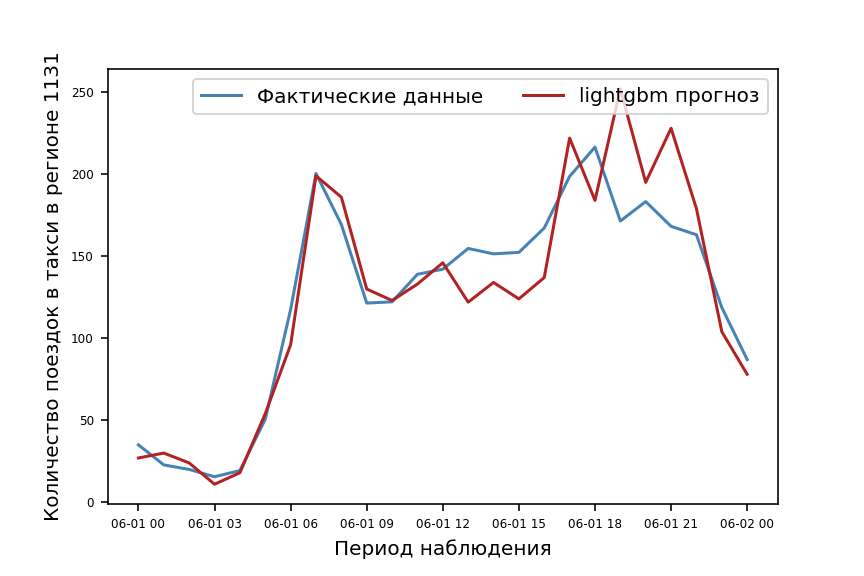

In [20]:
tabs = pn.Tabs(widg_col_ser, widg_col_map)
display(tabs)

Ссылка на демо: https://drive.google.com/file/d/1PPC5T-jhyv8r4GwreocVj6RcmXk36e4t/view?usp=sharing